# Guided Project: Predicting Bike Rentals

The goal is to predict the number of bike rentals using decision tree technique on a bike rental data set, as well as to compare the performance of decision tree and simple linear regression method.

The file we use is `bike_rental_hour.csv` compiled by Hadi Fanaee-T from University of Porto. The data set is downloadable [here from the University of California. Irvine's website](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

## 1. Introduction

(17379, 17)
   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1  


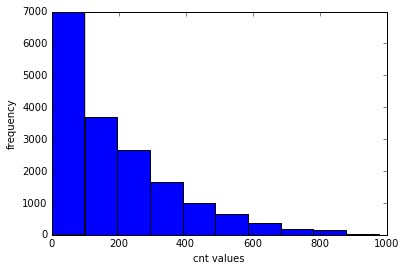

hum          -0.322911
weathersit   -0.142426
holiday      -0.030927
weekday       0.026900
workingday    0.030284
windspeed     0.093234
mnth          0.120638
season        0.178056
yr            0.250495
instant       0.278379
hr            0.394071
atemp         0.400929
temp          0.404772
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64


In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

bike_rentals = pd.read_csv("bike_rental_hour.csv")
print(bike_rentals.shape)
print(bike_rentals.head())
plt.hist(bike_rentals["cnt"])
plt.xlabel("cnt values")
plt.ylabel("frequency")
plt.show()
print(bike_rentals.corr()["cnt"].sort_values())

## 2.a Assign New Variables

In [2]:
def assign_label(hour):
    categories = [4, 1, 2, 3]
    return categories[hour//6] # 6-periodic

bike_rentals["time_label"] = bike_rentals["hr"].apply(assign_label)
print(bike_rentals.head(10))

   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   
5        6  2011-01-01       1   0     1   5        0        6           0   
6        7  2011-01-01       1   0     1   6        0        6           0   
7        8  2011-01-01       1   0     1   7        0        6           0   
8        9  2011-01-01       1   0     1   8        0        6           0   
9       10  2011-01-01       1   0     1   9        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  \
0           1  0.24  0.2879  0.81     0.0000       3          13   1

## 2.b Training and Predictions

We first separate the training and test data set in `bike_rentals`, with $80\%$ rows as training data.

The error metric we will use is RMS, since `cnt` has various values that can be estimated using regression. If it were of binary type that is predicted using classification model, ROC AUC would be a better metric.

For the list of columns to be used in training and predictions, we do not use the variables `registered` and `casual` to our ML algorithm, since the addition of both yields the value of `cnt` directly. Therefore we will exclude both columns from our ML feature columns and `cnt` (for obvious reason).

Furthermore, some columns are of categorical or nominal types instead of ordinal types, which are not suitable for linear regression. Most of these have low correlation values with `cnt`, thus we can try to select columns with `corr` value more than $0.2$.

Afterwards, the only categorical columns left are `instant`, `yr`, `hr`, and `time_label`. Column `instant` is not needed as it is for identification purpose, while column `hr` detail is already contained in `time_label`. Based on the dataset description, `yr` is a binary class, and thus can be included for linear regression. We can use dummy variable method to convert `time_label` to a set of binary columns.

In [3]:
train = bike_rentals.sample(frac = 0.8)
test = bike_rentals[~bike_rentals.index.isin(train.index)]
print(train.shape)
print(test.shape)

(13903, 18)
(3476, 18)


In [4]:
cnt_corr_table = bike_rentals.corr()["cnt"]
features = list(cnt_corr_table[np.abs(cnt_corr_table) > 0.2].index)
features = [x for x in features if x not in ["casual", "registered", "cnt", "instant", "hr", "time_label"]]

dummies = pd.get_dummies(bike_rentals["time_label"], prefix = "tl")
train = pd.concat([train, dummies], axis = 1) # Warning: do not re-run this line
train.dropna(inplace = True)
test = pd.concat([test, dummies], axis = 1)
test.dropna(inplace = True)

features.extend(list(dummies.columns))
print(features)

['yr', 'temp', 'atemp', 'hum', 'tl_1', 'tl_2', 'tl_3', 'tl_4']


## 3. Using Linear Regression

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lr = LinearRegression()
lr.fit(train[features], train["cnt"])
predictions = lr.predict(test[features])
mse = mean_squared_error(test["cnt"], predictions)
print("Linear regression MSE: ", mse)
print(predictions[:5])
print(test["cnt"].head())

Linear regression MSE:  17345.24881329114
[-75.625 123.    137.875 -59.    131.5  ]
4      1.0
21    34.0
23    39.0
26     9.0
32    20.0
Name: cnt, dtype: float64


Even with a good set of features, the MSE value seems to be very high in this approach (around $17,000$). One factor may be the error due to sampling, which can be reduced by cross validation. Another factor may be that the model did not catter the fact that `cnt` values are mainly very small (reaching $0$). Nevertheless, we need a better ML model to predict `cnt`.

## 4. Using Decision Tree

We tweak three parameters from `DecisionTreeRegressor` that may improve the performance of our decision tree method: `max_depth`, `min_samples_split`, `min_samples_leaf`. This is because decision trees are prone to overfitting the traning data. By trial and error, we pick `max_depth` as $8$ and `min_samples_leaf` as $25$.

In [6]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor(max_depth = 8,
                            min_samples_split = 2,
                            min_samples_leaf = 25)
dtr.fit(train[features], train["cnt"])
predictions = dtr.predict(test[features])
mse = mean_squared_error(test["cnt"], predictions)
print("Decision Tree MSE: ", mse)
print(predictions[:5])
print(test["cnt"].head())

Decision Tree MSE:  15046.408489675172
[ 11.18       126.60416667 126.60416667  13.7173913  142.27986348]
4      1.0
21    34.0
23    39.0
26     9.0
32    20.0
Name: cnt, dtype: float64


The decision tree seems to perform slightly better than linear regression. However, the number of MSE is still quite high.

## 5. Using Random Forest

Random forests are still prone to overfitting, although less than decision tree due to its randomness feature. We also experimented with parameters of `RandomForestRegressor` such as `max_depth`.

In [7]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(max_depth = 8,
                            min_samples_split = 2,
                            min_samples_leaf = 3)
rfr.fit(train[features], train["cnt"])
predictions = rfr.predict(test[features])
mse = mean_squared_error(test["cnt"], predictions)
print("Random Forest MSE: ", mse)
print(predictions[:5])
print(test["cnt"].head())

Random Forest MSE:  14701.789983347044
[ 11.67548286 122.31321365 119.88432617  11.98274481 134.4059771 ]
4      1.0
21    34.0
23    39.0
26     9.0
32    20.0
Name: cnt, dtype: float64


Random forest here works slightly better than decision tree. This might be due to feature selection, where we restricted many variables with low correlation scores.

## 6. Conclusion